In [1]:
import rfest

from sklearn.utils.extmath import randomized_svd
import matplotlib.pyplot as plt
%matplotlib inline

from rfest._utils import get_sdm

## Generate toy dataset

RFEst comes with a simple data generator. Here we generated a stimulus-response pair with a 3D Difference-of-Gaussian filter.

In [28]:
((X, Y), (Xtest, Ytest), 
 w_true) = rfest.make_data(dims=(9, 9), sigma=(1.5, 1.5),
                           n_samples=1000, nsevar=1, 
                           filter_type='mexican_hat', seed=2046)
                          

### ASD

============0============
sigma: 0.9971890115746275
rho: -2.3
delta: 1.0
cost: 27.30916800842791


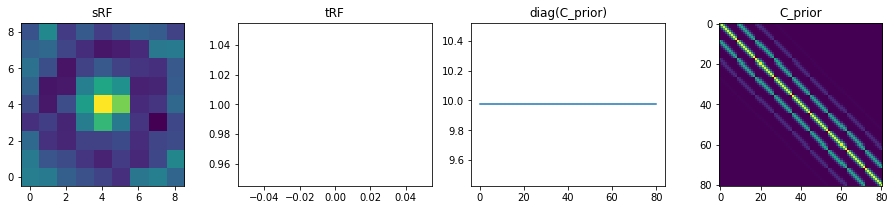

============5============
sigma: 1.0021870107535575
rho: -2.295000013467903
delta: 1.0050005217106734
cost: 27.309171137715644


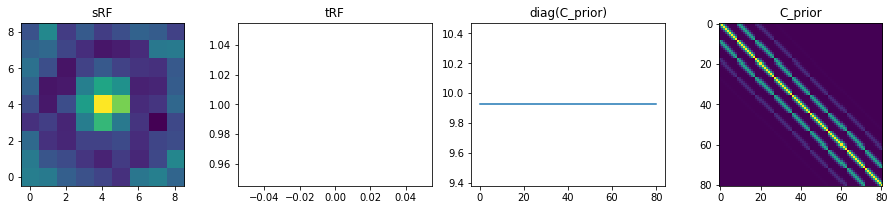

============10============
sigma: 1.0071741436945874
rho: -2.2900001028417845
delta: 1.0100038476747515
cost: 27.309174724192978


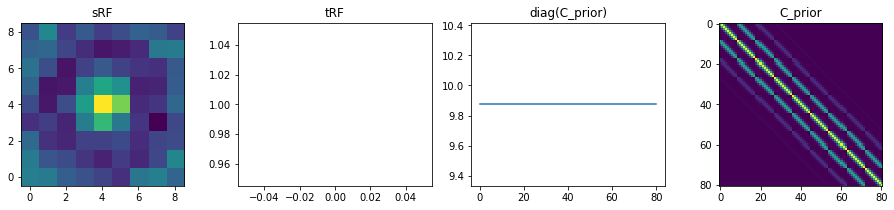

============15============
sigma: 1.0121411601117594
rho: -2.2850003406327817
delta: 1.015012294313274
cost: 27.309178836648517


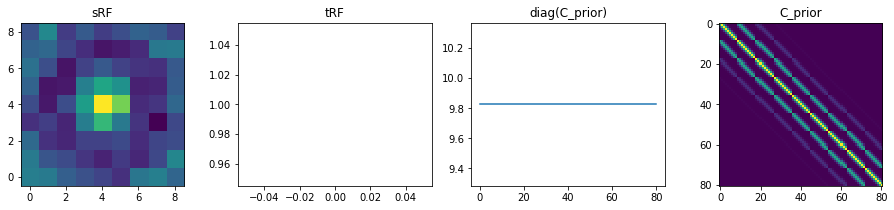

============20============
sigma: 1.0170798866029822
rho: -2.280000800458353
delta: 1.0200278441426203
cost: 27.309183554369344


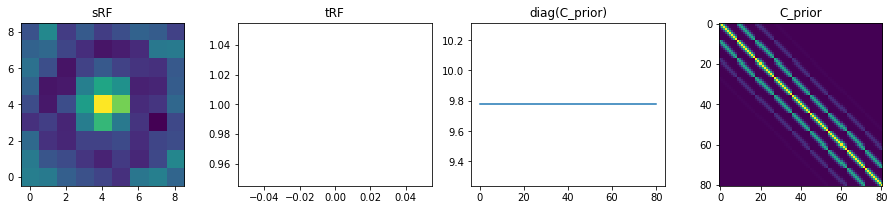

KeyboardInterrupt: 

In [30]:
cost_list = []
import numpy as np
def callback(params, t, g):
    if t % 5 == 0:
        print('============{}============'.format(t))
        print('sigma: {0}'.format(params[0]))
        print('rho: {0}'.format(params[1]))
        print('delta: {0}'.format(params[2])) 
            
        (C_prior, 
         C_prior_inv) = opt.update_C_prior(params)
        
        (C_post, 
         C_post_inv, 
         m_post) = opt.update_posterior(params,
                                        C_prior,
                                        C_prior_inv)  
        
        cost = np.linalg.norm(opt.Y -opt.X @ m_post.reshape(np.product([*m_post.shape]), 1))
        cost_list.append(cost)
        print('cost: {0}'.format(cost))
        
        k,S,kt = randomized_svd(m_post, 3)
        
        fig, ax = plt.subplots(1,4, figsize=(16,3))
        
        ax[0].imshow(k[:, 0].reshape(9,9), origin='lower')
        ax[1].plot(kt[0])
        ax[2].plot(np.diag(C_prior))
        ax[3].imshow(C_prior)
        
        ax[0].set_title('sRF')
        ax[1].set_title('tRF')
        ax[2].set_title('diag(C_prior)')
        ax[3].set_title('C_prior')
        
        plt.show()
        
opt = rfest.ASD(X, Y, rf_dims=(9,9))

opt.fit(num_iters=5000,callback=callback)

print('============Optimized============')
opt_params = opt.optimized_params
print('sigma: {0}'.format(opt_params[0]))
print('rho: {0}'.format(opt_params[1]))
print('delta: {0}'.format(opt_params[2])) 
    
(C_prior, 
 C_prior_inv) = opt.update_C_prior(opt_params)

(C_post, 
 C_post_inv, 
 m_post) = opt.update_posterior(opt_params,
                                C_prior,
                                C_prior_inv)  

cost = np.linalg.norm(opt.Y - opt.X @ m_post.reshape(np.product([*m_post.shape]), 1))
cost_list.append(cost)
print('cost: {0}'.format(cost))

In [ ]:
U_true, S, Vt_true = randomized_svd(w_true.reshape(300,5), 3)

fig, ax = plt.subplots(3,2, figsize=(9, 9))
ax[0, 0].imshow(U_true[:, 0].reshape(15, 20), origin='lower')
ax[0, 1].plot(Vt_true[0])

ax[1, 0].imshow(opt.sRF_mle, origin='lower')
ax[1, 1].plot(opt.tRF_mle)

ax[2, 0].imshow(opt.sRF_opt, origin='lower')
ax[2, 1].plot(opt.tRF_opt)


ax[0,0].set_title('s_true')
ax[0,1].set_title('t_true')

ax[1,0].set_title('s_mle')
ax[1,1].set_title('t_mle')

ax[2,0].set_title('s_asd')
ax[2,1].set_title('t_asd')

Text(0,0.5,'Prediction Error')

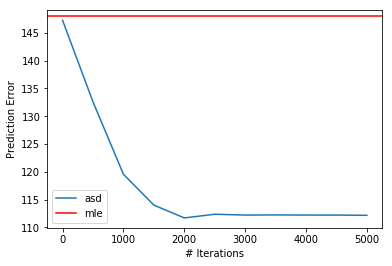

In [5]:
cost_mle = np.linalg.norm(opt.Y - get_sdm(opt.X, 5) @ opt.w_mle.reshape(np.product([*m_post.shape]), 1))

plt.plot(np.linspace(0, 5000, 11), cost_list, label='asd')
plt.axhline(cost_mle, color='red', label='mle')
plt.legend()
plt.xlabel('# Iterations')
plt.ylabel('Prediction Error')